## 0. 데이터 불러오기

### 0.1. 기본 설정

In [ ]:
'''
numpy == 1.23.5
pandas == 1.5.3
matplotlib == 3.7.1
'''
from typing import Tuple, List

import os
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt

%matplotlib inline

### 0.2. random seed 고정

In [ ]:
seed = 0

random.seed(seed)
np.random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# 데이터 불러오기
ratings_df = pd.read_csv('/content/drive/MyDrive/가짜연구소/data/ml-latest-small/ratings.csv', encoding='utf-8')

---

## 1. MF SGD

- SGD: Stochastic Gradient Descent
- MF: Matrix Factorization

In [ ]:
def sgd(
    P: np.ndarray,
    Q: np.ndarray,
    b: float,
    b_u: np.ndarray,
    b_i: np.ndarray,
    samples: List[Tuple],
    learning_rate: float,
    regularization: float
) -> None:
    """
    MF의 파라미터를 업데이트하는 SGD 구현
    P: (np.ndarray) 유저의 잠재 요인 행렬. shape: (유저 수, 잠재 요인 수)
    Q: (np.ndarray) 아이템의 잠재 요인 행렬. shape: (아이템 수, 잠재 요인 수)
    b: (float) 글로벌 bias
    b_u: (np.ndarray) 유저별 bias
    b_i: (np.ndarray) 아이템별 bias
    samples: (List[Tuple]) 학습 데이터 (실제 평가를 내린 데이터만 학습에 사용함)
                    (user_id, item_id, rating) tuple을 element로 하는 list임
    learning_rate: (float) 학습률
    regularization: (float) L2 정규화 파라미터
    return: None
    """
    for user_id, item_id, rating in samples:

        # 1. predicted rating 계산
        predicted_rating = np.dot(P[user_id, :], Q[item_id, :].T)

        # 2. 실제 rating과 predicted rating의 차 = error
        error = rating - b - b_u[user_id] - b_i[item_id] - predicted_rating

        # 3. error로 유저와 아이템의 bias 업데이트
        b_u[user_id] += learning_rate*(error - regularization*b_u[user_id])
        b_i[item_id] += learning_rate*(error - regularization*b_i[item_id])

        # 4. error를 통해 유저와 아이템의 잠재 요인 행렬 업데이트
        P[user_id, :] +=  learning_rate*(error*Q[item_id, :]- regularization*P[user_id, :])
        Q[item_id, :] +=  learning_rate*(error*P[user_id, :]- regularization*Q[item_id, :])

### 1.2. 유저와 아이템의 잠재 요인 행렬($P$, $Q$)과 글로벌, 유저, 아이템 bias($b$, $b_u$, $b_i$)를 활용하여 예측된 유저-아이템 rating 매트릭스($\hat{R}$)를 구하는 함수를 구현

- bias가 없을 때
<p style="font-size:16px">
    $$\hat{R} = PQ^T$$
</p>

- bias가 있을 때
<p style="font-size:16px">
    $$\hat{R} = PQ^T + \mathbb{1}_{|U|}b_i ^ T + b_u \mathbb{1}_{|I|}^{T} + b \mathbb{1}_{|U|} \mathbb{1}_{|I|}^{T} $$
</p>



In [ ]:
def get_predicted_full_matrix(
    P: np.ndarray,
    Q: np.ndarray,
    b: float = None,
    b_u: np.ndarray = None,
    b_i: np.ndarray = None
) -> np.ndarray:
    """
    유저와 아이템의 잠재 요인 행렬과 글로벌, 유저, 아이템 bias를 활용하여 예측한 user-item rating matrix

    P: (np.ndarray) 유저의 잠재 요인 행렬. shape: (유저 수, 잠재 요인 수)
    Q: (np.ndarray) 아이템의 잠재 요인 행렬. shape: (아이템 수, 잠재 요인 수)
    b: (float) 글로벌 bias
    b_u: (np.ndarray) 유저별 bias
    b_i: (np.ndarray) 아이템별 bias
    return: (np.ndarray) 예측된 유저-아이템 rating 매트릭스. shape: (유저 수, 아이템 수)
    """
    if b is None: # bias가 없을 경우
        return  P@Q.T
    else: # bias가 있을 경우
        return  P@Q.T +  b_i[np.newaxis, :] +  b_u[:, np.newaxis]+ b


### 1.3.  1.2.에서 구한 $\hat{R}$를 활용하여 전체 학습 데이터에 대한 RMSE를 계산하는 함수 구현

<p style="font-size:16px">
    $$RMSE(\hat{\theta}) = \sqrt{MSE(\hat{\theta})} = \sqrt{\mathbb{E}({(\hat{\theta} - \theta)}^2)}$$
</p>

In [ ]:
def get_rmse(
    R: np.ndarray,
    predicted_R: np.ndarray
) -> float:
    """
    학습 데이터에 대한 RMSE 계산

    R: (np.ndarray) 유저-아이템 rating 매트릭스. shape: (유저 수, 아이템 수)
    predicted_R: (np.ndarray) 예측된 유저-아이템 rating 매트릭스. shape: (유저 수, 아이템 수)
    return: (float) RMSE
    """

    user_index, item_index = R.nonzero()
    error = list()
    for user_id, item_id in zip(user_index, item_index):
        square_error =  (predicted_R[user_id, item_id] - R[user_id, item_id])**2
        error.append(square_error)
    rmse =  np.sqrt(np.mean(error))
    return rmse


### 1.4. MF 구현

In [ ]:
class MF(object):

    def __init__(self, R, K, learning_rate, regularization, epochs, verbose=False):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.epochs = epochs
        self.verbose = verbose

        self.training_process = list()

    def train(self):

        # 유저, 아이템 잠재 요인 행렬 초기화
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # 글로벌, 유저, 아이템 bias 초기화
        self.b = np.mean(self.R[np.where(self.R != 0)])
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)

        # 학습 데이터 생성
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        for epoch in range(1, self.epochs + 1):
            np.random.shuffle(self.samples)
            sgd(self.P, self.Q, self.b, self.b_u, self.b_i, self.samples, self.learning_rate, self.regularization)
            predicted_R = self.get_predicted_full_matrix()
            rmse = get_rmse(self.R, predicted_R)
            self.training_process.append((epoch, rmse))
            if self.verbose and (epoch % 10 == 0):
                print("epoch: %d, error = %.4f" % (epoch, rmse))

        self.training_process = pd.DataFrame(self.training_process, columns = ['epoch', 'rmse'])

    def get_predicted_full_matrix(self):
        return get_predicted_full_matrix(self.P, self.Q, self.b, self.b_u, self.b_i)

---

## 2. SVD 기반 MF 모델
### 2.1. 학습 데이터, 하이퍼 파라미터 초기화

In [ ]:
user_item_matrix = ratings_df.pivot_table('rating', 'userId', 'movieId').fillna(0)

# 유저-아이템 rating 매트릭스
R = user_item_matrix.to_numpy()

# 잠재 요인 수
K = 20

# learning rate
learning_rate = 0.01

# l2 정규화 파라미터
regularization = 0.2

# 총 epoch 수
epochs = 30

# 학습 과정의 status print 옵션
verbose = True

In [ ]:
mf = MF(R, K, learning_rate, regularization, epochs, verbose)

### 2.2. 모델 학습

In [ ]:
mf.train()

epoch: 10, error = 0.8349
epoch: 20, error = 0.8207
epoch: 30, error = 0.8133


### 2.3. training error (RMSE)

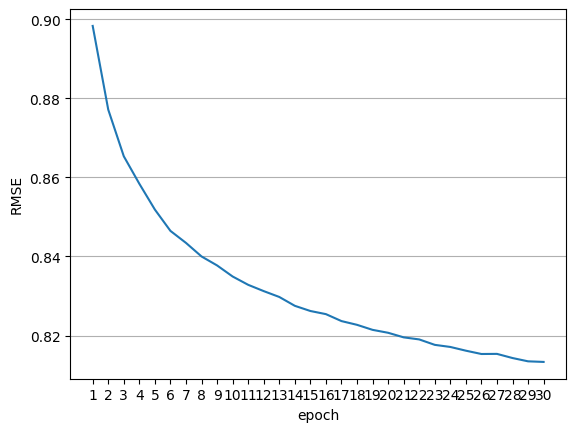

In [ ]:
train_result_df = mf.training_process

x = train_result_df.epoch.values
y = train_result_df.rmse.values
plt.plot(x, y)
plt.xticks(x, x)
plt.title("training error(RMSE)")
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.grid(axis="y")
plt.show()

### 2.5.  예측된 user-item rating matrix

In [ ]:
predicted_user_item_matrix = pd.DataFrame(mf.get_predicted_full_matrix(), columns=user_item_matrix.columns, index=user_item_matrix.index)

predicted_user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.439098,4.034819,3.866303,3.244842,3.654554,4.441955,3.760433,3.549879,3.656476,4.066811,...,4.076021,3.951082,4.205615,4.203078,4.079550,4.202697,4.069275,4.071959,4.076074,4.233465
2,3.940923,3.534855,3.365342,2.748890,3.154983,3.943350,3.261576,3.058201,3.155908,3.567598,...,3.578362,3.462842,3.713145,3.701445,3.576400,3.701193,3.568870,3.578255,3.585746,3.725865
3,2.865359,2.464080,2.292437,1.637076,2.080064,2.885577,2.183874,1.986490,2.077697,2.509568,...,2.552560,2.301331,2.634675,2.660495,2.559692,2.631841,2.585098,2.567266,2.438364,2.604819
4,3.683274,3.278844,3.111814,2.487270,2.899123,3.686225,3.004950,2.794662,2.900490,3.311404,...,3.322365,3.200816,3.450160,3.443591,3.326586,3.444391,3.309373,3.319193,3.317832,3.478434
5,3.838377,3.433256,3.263514,2.642786,3.052393,3.840934,3.158946,2.948001,3.055074,3.465652,...,3.468672,3.353564,3.606177,3.599931,3.475312,3.598915,3.467508,3.468958,3.477886,3.630644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,3.911593,3.506958,3.338060,2.717288,3.126187,3.914639,3.232406,3.021788,3.128155,3.539048,...,3.546640,3.424015,3.676824,3.675278,3.551371,3.675950,3.542932,3.545400,3.548452,3.704075
607,4.073708,3.669294,3.500704,2.879488,3.289443,4.076961,3.396805,3.186346,3.290769,3.701674,...,3.711063,3.588577,3.845912,3.838071,3.712936,3.839425,3.704996,3.710799,3.714532,3.869270
608,3.710346,3.306009,3.136708,2.513880,2.925776,3.713329,3.031464,2.819714,2.927133,3.338388,...,3.343770,3.222737,3.476202,3.475305,3.349651,3.475538,3.343058,3.345688,3.346934,3.502281


---

## 3. ALS 기반 MF 모델
- ALS: Alternating Least Square

### 3.1. MF의 파라미터를 업데이트하는 ALS 구현

<p style="font-size:16px">
$$p_u = {(Q^{T}C^{u}Q + {\lambda}I)^{-1}Q^{T}C^{u}f_{u}}$$
</p><p style="font-size:16px">
$$q_i = {(P^{T}C^{i}P + {\lambda}I)^{-1}P^{T}C^{i}f_{i}}$$
</p>

In [ ]:
def als(
    F: np.ndarray,
    P: np.ndarray,
    Q: np.ndarray,
    C: np.ndarray,
    K: int,
    regularization: float
) -> None:
    """
    MF의 파라미터를 업데이트하는 ALS 구현
    ***********************************************************************************************************
    ALS:
        1. 모든 유저에 대하여 유저의 잠재 요인 행렬을 업데이트
        2. 모든 아이템에 대하여 아이템의 잠재 요일 행렬 업데이트
    ***********************************************************************************************************
    :param F: (np.ndarray) 유저-아이템 preference 매트릭스. shape: (유저 수, 아이템 수)
    :param P: (np.ndarray) 유저의 잠재 요인 행렬. shape: (유저 수, 잠재 요인 수)
    :param Q: (np.ndarray) 아이템의 잠재 요인 행렬. shape: (아이템 수, 잠재 요인 수)
    :param C: (np.ndarray) 평점 테이블에 Confidence Level을 적용한 행렬. shape: (유저 수, 아이템 수)
    :param K: (int) 잠재 요인 수
    :param regularization: (float) l2 정규화 파라미터
    :return: None
    """
    for user_id, F_user in enumerate(F):
        C_u = np.diag(C[user_id])
        P[user_id] =  np.linalg.solve(np.dot(Q.T,np.dot(C_u, Q)) + regularization * np.eye(K), np.dot(Q.T, np.dot(C_u, F_user)))
    for item_id, F_item in enumerate(F.T):
        C_i = np.diag(C[:, item_id])
        Q[item_id] = np.linalg.solve(np.dot(P.T,np.dot(C_i, P)) + regularization * np.eye(K), np.dot(P.T, np.dot(C_i, F_item)))

### 3.2. ALS의 Loss Function을 계산하는 함수 구현

<p style="font-size:16px">
$$\sum_{observed~f_{u,i}} {c_{u,i}{(f_{u,i} - p_{u}^Tq_{i})}^{2} + \lambda(\sum_{u}{||p_u ||}^{2}_{2} + \sum_{i}{||q_i ||}^{2}_{2})}$$
</p>

In [ ]:
def get_ALS_loss(
    F: np.ndarray,
    P: np.ndarray,
    Q: np.ndarray,
    C: np.ndarray,
    regularization: float
) -> float:
    """
    학습 데이터에 대한 ALS의 Loss 계산
    :param F: (np.ndarray) 유저-아이템 preference 매트릭스. shape: (유저 수, 아이템 수)
    :param P: (np.ndarray) 유저의 잠재 요인 행렬. shape: (유저 수, 잠재 요인 수)
    :param Q: (np.ndarray) 아이템의 잠재 요인 행렬. shape: (아이템 수, 잠재 요인 수)
    :param C: (np.ndarray) 평점 테이블에 Confidence Level을 적용한 행렬. shape: (유저 수, 아이템 수)
    :param regularization: (float) l2 정규화 파라미터
    :return: (float) 전체 학습 데이터에 대한 Loss
    """

    user_index, item_index = F.nonzero()
    loss = 0
    for user_id, item_id in zip(user_index, item_index):
        predict_error = F[user_id, item_id] - np.dot(P[user_id, :], Q[item_id, :])
        confidence_error = C[user_id, item_id] * predict_error**2
        loss += confidence_error

    for user_id in range(F.shape[0]):
        regularization_term = regularization * np.sum(P[user_id, :]**2)
        loss += regularization_term

    for item_id in range(F.shape[1]):
        regularization_term = regularization * np.sum(Q[item_id, :]**2)
        loss += regularization_term

    return loss


### 3.3. ALS 기반 MF 구현

- 3.1 ~ 3.2에서 구현한 함수들을 활용하여 ALS로 업데이트하는 MF를 구현

In [ ]:
class MF_ALS(object):

    def __init__(self, F, K, C, regularization, epochs, verbose=False):
        self.F = F
        self.num_users, self.num_items = F.shape
        self.K = K
        self.C = C
        self.regularization = regularization
        self.epochs = epochs
        self.verbose = verbose

        self.training_process = list()

    def train(self):

        # 유저, 아이템 잠재 요인 행렬 초기화
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        for epoch in range(1, self.epochs + 1):
            als(self.F, self.P, self.Q, self.C, self.K, self.regularization)
            loss = get_ALS_loss(self.F, self.P, self.Q, self.C, self.regularization)
            self.training_process.append((epoch, loss))
            if self.verbose and (epoch % 10 == 0):
                print("epoch: %d, error = %.4f" % (epoch, loss))

        self.training_process = pd.DataFrame(self.training_process, columns = ['epoch', 'rmse'])

    def get_predicted_full_matrix(self):
        return get_predicted_full_matrix(self.P, self.Q)

---

## 4. ALS 기반 MF 모델 학습

### 4.1. MovieLens 데이터의 일부를 Implicit Feedback 데이터(좋아요/싫어요)로 변환

In [ ]:
user_item_matrix = ratings_df.pivot_table('rating', 'userId', 'movieId').fillna(0)

In [ ]:
user_num = int(user_item_matrix.shape[0] / 10)
movie_num = int(user_item_matrix.shape[1] / 10)
preference_matrix = np.copy(user_item_matrix.iloc[:user_num,:movie_num])
preference_matrix[preference_matrix > 0] = 1

In [ ]:
preference_matrix

array([[1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### 4.2. 신뢰도 행렬 $C$, 잠재 요인 수, l2 정규화 파라미터 설정

In [ ]:
# 신뢰도 행렬 (C)
alpha = 40
C = 1 + alpha * np.copy(preference_matrix)

# 잠재 요인 수
K = 200

# l2 정규화 파라미터
regularization = 40

# 총 epoch 수
epochs = 500

# 학습 과정의 status print 옵션
verbose = True

### 4.3. ALS 기반 MF 모델 학습

In [ ]:
mf_als = MF_ALS(preference_matrix, K, C, regularization, epochs, verbose)
mf_als.train()

epoch: 10, error = 18663.2532
epoch: 20, error = 18326.3785
epoch: 30, error = 18306.0359
epoch: 40, error = 18302.9864
epoch: 50, error = 18302.1073
epoch: 60, error = 18301.6992
epoch: 70, error = 18301.4598
epoch: 80, error = 18301.3037
epoch: 90, error = 18301.1955
epoch: 100, error = 18301.1172
epoch: 110, error = 18301.0586
epoch: 120, error = 18301.0135
epoch: 130, error = 18300.9780
epoch: 140, error = 18300.9493
epoch: 150, error = 18300.9257
epoch: 160, error = 18300.9060
epoch: 170, error = 18300.8893
epoch: 180, error = 18300.8749
epoch: 190, error = 18300.8624
epoch: 200, error = 18300.8513
epoch: 210, error = 18300.8416
epoch: 220, error = 18300.8328
epoch: 230, error = 18300.8250
epoch: 240, error = 18300.8179
epoch: 250, error = 18300.8115
epoch: 260, error = 18300.8056
epoch: 270, error = 18300.8002
epoch: 280, error = 18300.7953
epoch: 290, error = 18300.7908
epoch: 300, error = 18300.7866
epoch: 310, error = 18300.7828
epoch: 320, error = 18300.7792
epoch: 330, error

### 4.4. training error (RMSE)

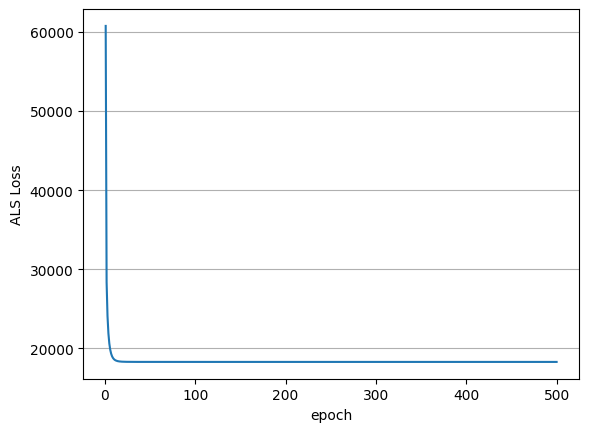

In [ ]:
train_result_df = mf_als.training_process

x = train_result_df.epoch.values
y = train_result_df.rmse.values
plt.plot(x, y)
plt.title("training error(RMSE)")
plt.xlabel("epoch")
plt.ylabel("ALS Loss")
plt.grid(axis="y")
plt.show()

### 4.5.  예측된 유저-아이템 preference matrix

In [ ]:
predicted_user_item_preference = pd.DataFrame(mf_als.get_predicted_full_matrix(), columns=user_item_matrix.iloc[:user_num,:movie_num].columns, index=user_item_matrix.iloc[:user_num,:movie_num].index)

predicted_user_item_preference

movieId,1,2,3,4,5,6,7,8,9,10,...,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273
userId,,,,,,,,,,,,,,,,,,,,,
1,0.933895,0.507474,0.877592,0.014815,0.349507,0.925093,0.445545,0.217556,0.0,0.486605,...,0.0,0.946707,0.341692,0.306630,0.205368,0.324559,0.986604,0.181226,0.193462,0.103790
2,0.171032,0.081092,0.139171,0.058645,0.097876,0.131902,0.126559,0.030273,0.0,0.193260,...,0.0,0.110661,-0.035772,0.060372,-0.024727,0.000958,0.055200,0.005632,0.081579,0.022423
3,0.247909,0.141110,0.132682,0.041583,-0.044033,-0.080621,0.101044,0.080291,0.0,-0.019365,...,0.0,0.085954,0.125871,0.215730,0.036354,0.165880,0.272655,0.125437,0.739039,0.169320
4,0.599564,0.244641,0.339345,0.195892,0.249400,0.422057,0.538652,0.125720,0.0,0.115406,...,0.0,0.964117,0.892449,0.353922,0.197878,0.328940,0.497254,0.320193,0.123395,0.182651
5,0.922024,0.444056,0.332695,0.217785,0.255549,0.481228,0.433301,0.239633,0.0,0.599023,...,0.0,0.494400,0.224839,0.041109,0.101012,0.026739,0.161465,0.310196,0.077717,0.084581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1.029149,0.673955,0.712621,0.029784,0.265377,1.017868,0.530599,0.294614,0.0,0.960598,...,0.0,0.972808,0.958062,0.372782,0.864738,0.928658,0.979270,0.264285,0.304900,0.264621
58,0.882857,0.604433,0.910614,0.520374,0.862706,0.602922,0.979826,0.389597,0.0,0.789246,...,0.0,0.763114,0.292645,0.059274,0.034126,0.082100,0.450132,0.277403,0.104232,-0.057395
59,0.670494,0.410806,0.245810,0.150000,0.064659,0.556708,0.315320,-0.013278,0.0,0.868676,...,0.0,0.531311,0.400236,0.458386,0.159306,0.800586,0.957238,0.117317,0.523431,0.269581
